In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
np.random.seed(42)
tf.random.set_seed(42)


print(f"TensorFlow version: {tf.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.18.0
Numpy version: 1.26.4
Pandas version: 2.2.3


In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 5

In [16]:
def load_data():
    
    data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/"
    train_normal_dir = os.path.join(data_dir, "train/NORMAL/")
    test_normal_dir = os.path.join(data_dir, "test/NORMAL/")
    test_pneumonia_dir = os.path.join(data_dir, "test/PNEUMONIA/")
    
    print(f"Number of normal training images: {len(os.listdir(train_normal_dir))}")
    print(f"Number of normal test images: {len(os.listdir(test_normal_dir))}")
    print(f"Number of pneumonia test images: {len(os.listdir(test_pneumonia_dir))}")
    
   
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
   
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,  # No labels needed for autoencoder
        color_mode='grayscale',
        classes=['NORMAL'],
        subset='training',
        shuffle=True
    )
    
    validation_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='grayscale',
        classes=['NORMAL'],
        subset='validation',
        shuffle=True
    )
    
   
    test_normal_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, "test"),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='grayscale',
        classes=['NORMAL'],
        shuffle=False
    )
    
    test_pneumonia_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, "test"),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='grayscale',
        classes=['PNEUMONIA'],
        shuffle=False
    )
    
    return train_generator, validation_generator, test_normal_generator, test_pneumonia_generator


In [17]:
def build_autoencoder():
    input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [18]:
def compute_reconstruction_error(model, images):
    predictions = model.predict(images)
    
    mse = np.mean(np.square(images - predictions), axis=(1, 2, 3))
    return mse, predictions

In [21]:
def plot_reconstructions(original_images, reconstructed_images, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        
        plt.subplot(2, n, i+1)
        plt.imshow(original_images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        
        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed_images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_roc_curve(normal_errors, pneumonia_errors):
    
    y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(pneumonia_errors))])
    y_scores = np.concatenate([normal_errors, pneumonia_errors])
    
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return roc_auc, thresholds

In [24]:
def plot_error_distributions(normal_errors, pneumonia_errors):
    plt.figure(figsize=(12, 8))
    sns.histplot(normal_errors, color='green', label='Normal', alpha=0.5, kde=True)
    sns.histplot(pneumonia_errors, color='red', label='Pneumonia', alpha=0.5, kde=True)
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [25]:
def find_optimal_threshold(normal_errors, pneumonia_errors):
    y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(pneumonia_errors))])
    y_scores = np.concatenate([normal_errors, pneumonia_errors])
    
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall[:-1], precision[:-1], color='purple', lw=2)
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', s=100, label=f'Optimal Threshold: {optimal_threshold:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return optimal_threshold


Number of normal training images: 1341
Number of normal test images: 234
Number of pneumonia test images: 390
Found 1073 images belonging to 1 classes.
Found 268 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Found 390 images belonging to 1 classes.
Training the model...
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 0.0262 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.0041 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.0035 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 0.0030 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.0028 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.0027 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - los

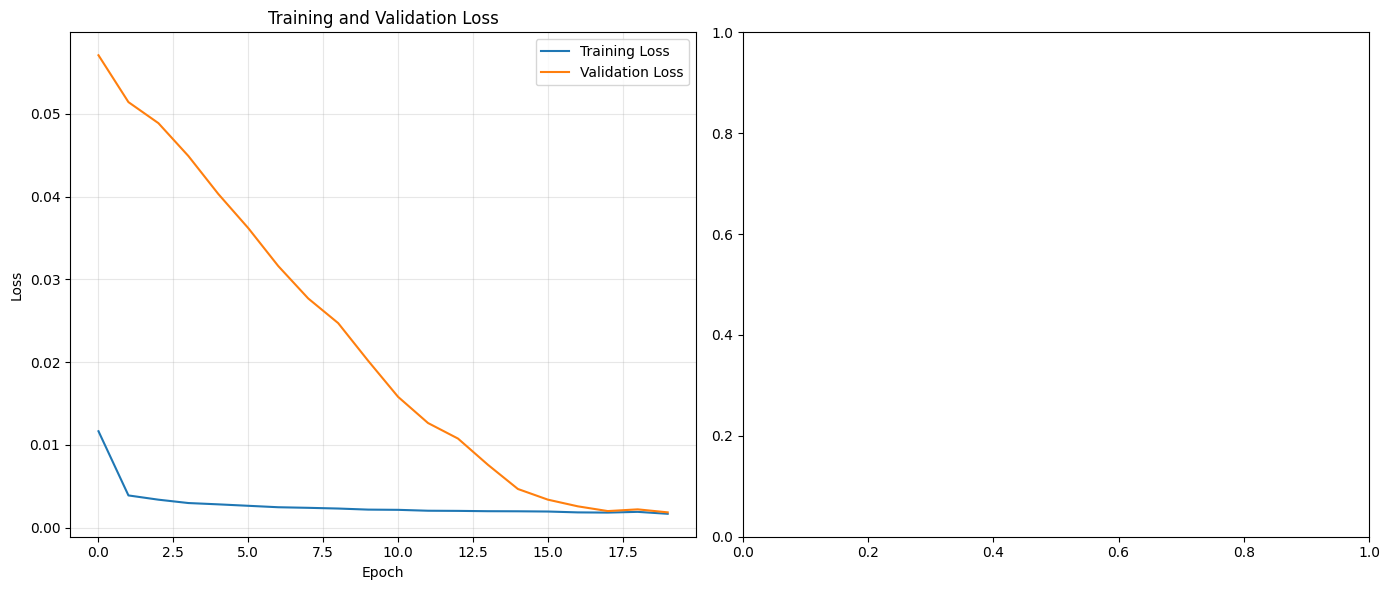

Computing reconstruction errors...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
Plotting sample reconstructions for normal cases...


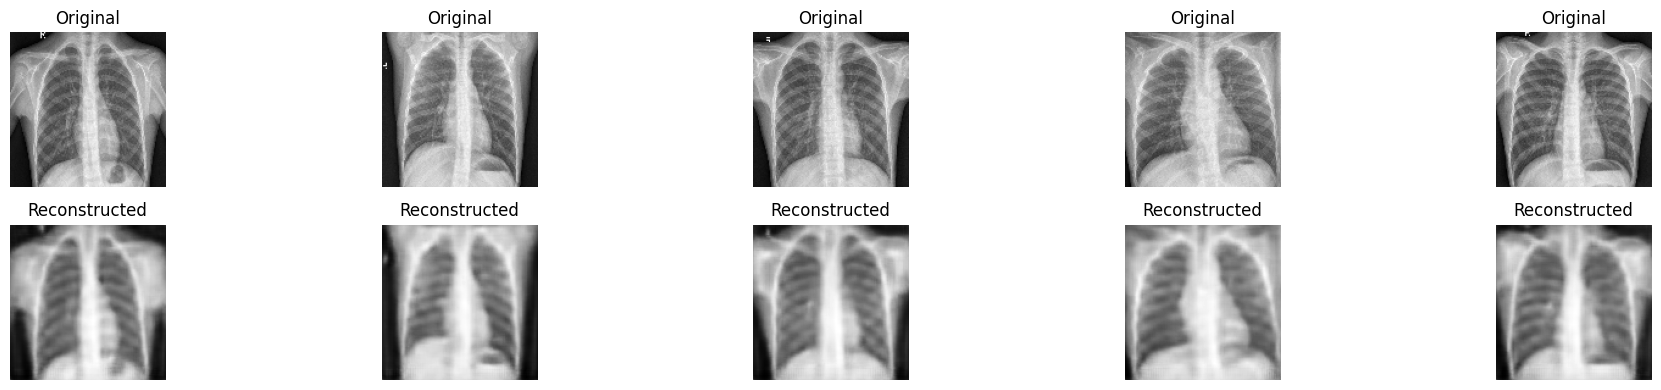

Plotting sample reconstructions for pneumonia cases...


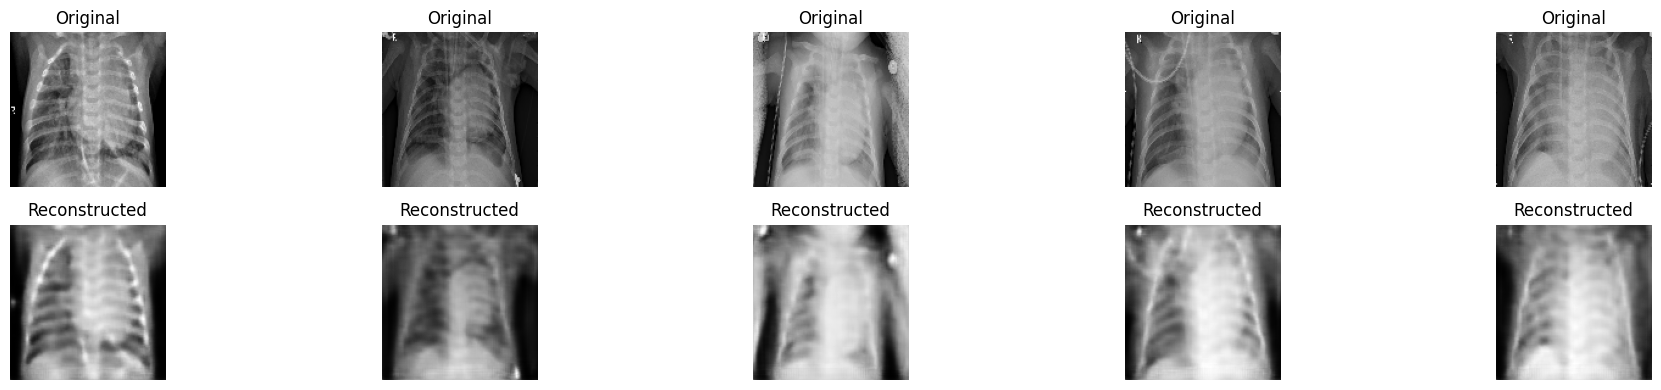

Plotting error distributions...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


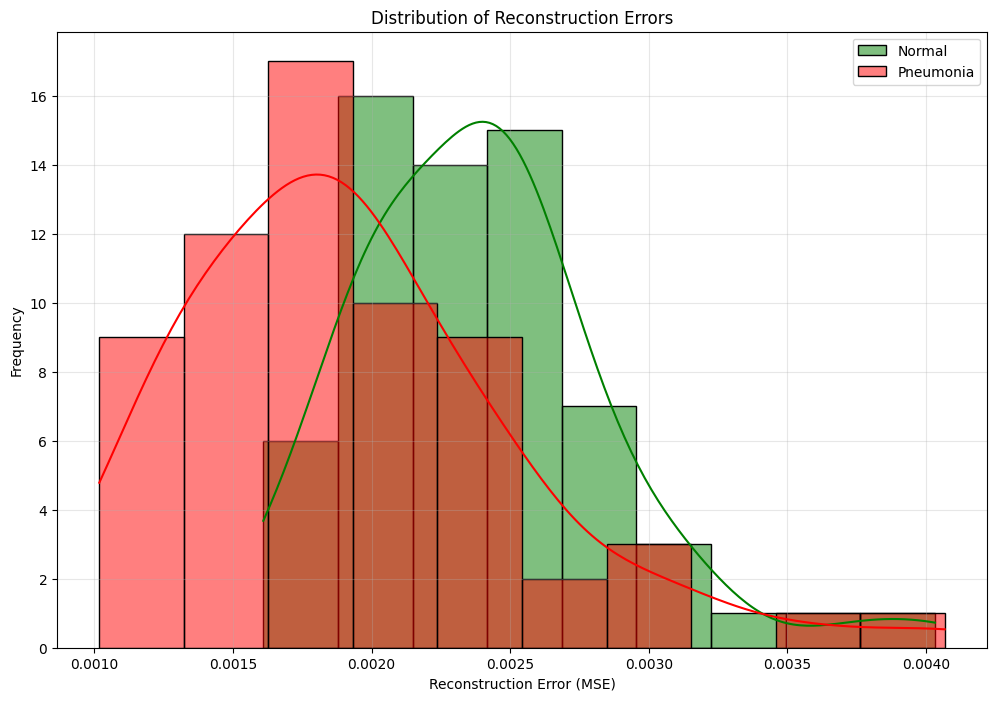

Plotting ROC curve...


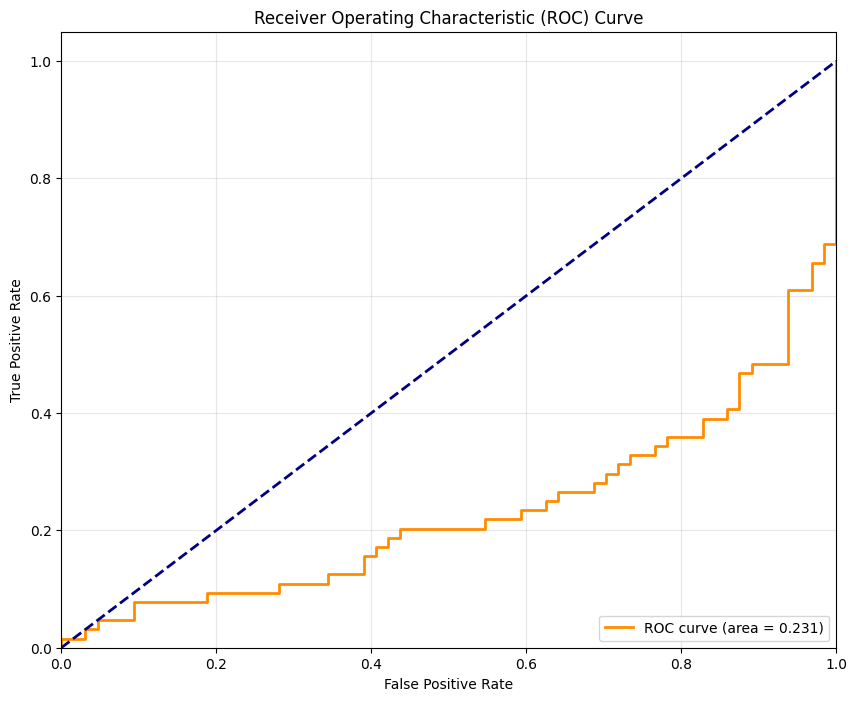

ROC AUC: 0.2312
Finding optimal threshold for anomaly detection...


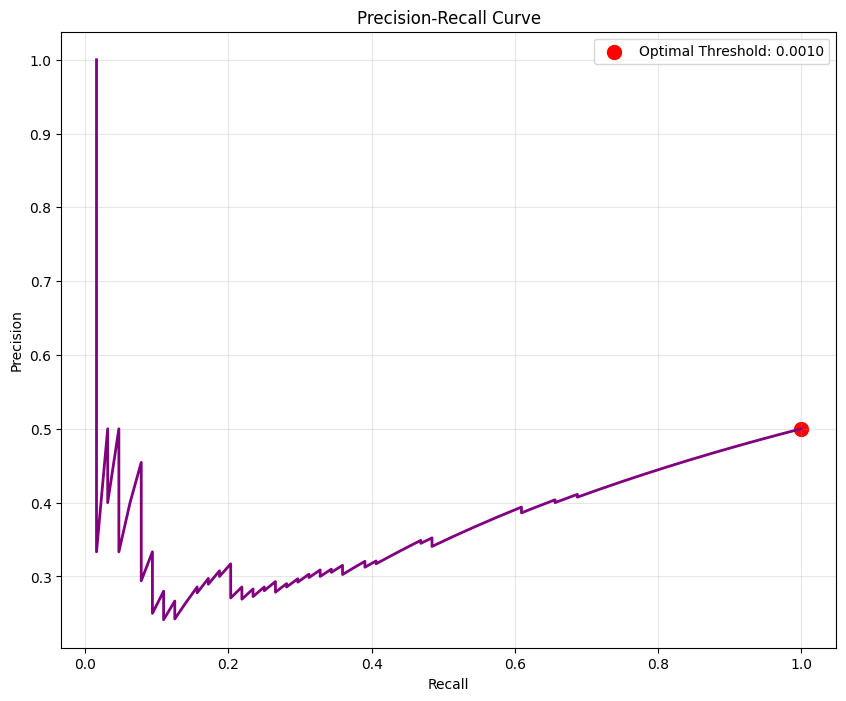

Optimal threshold: 0.0010
Evaluating performance at optimal threshold...


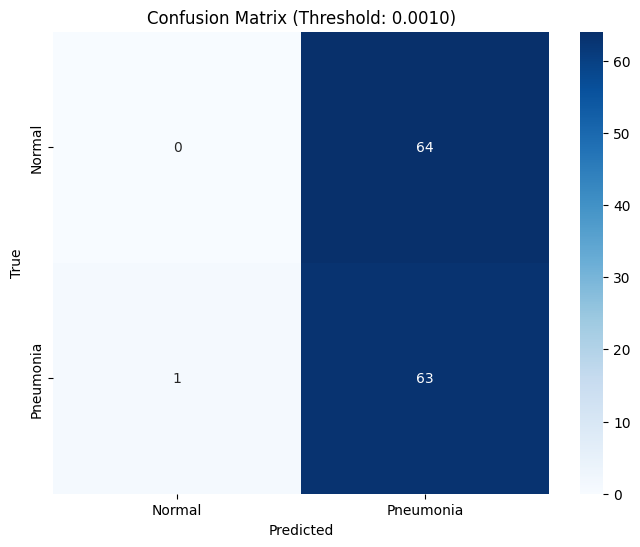

Accuracy: 0.4922
Sensitivity: 0.9844
Specificity: 0.0000
Precision: 0.4961
F1 Score: 0.6597


/tmp/ipykernel_74/4125790884.py:146: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i+1)


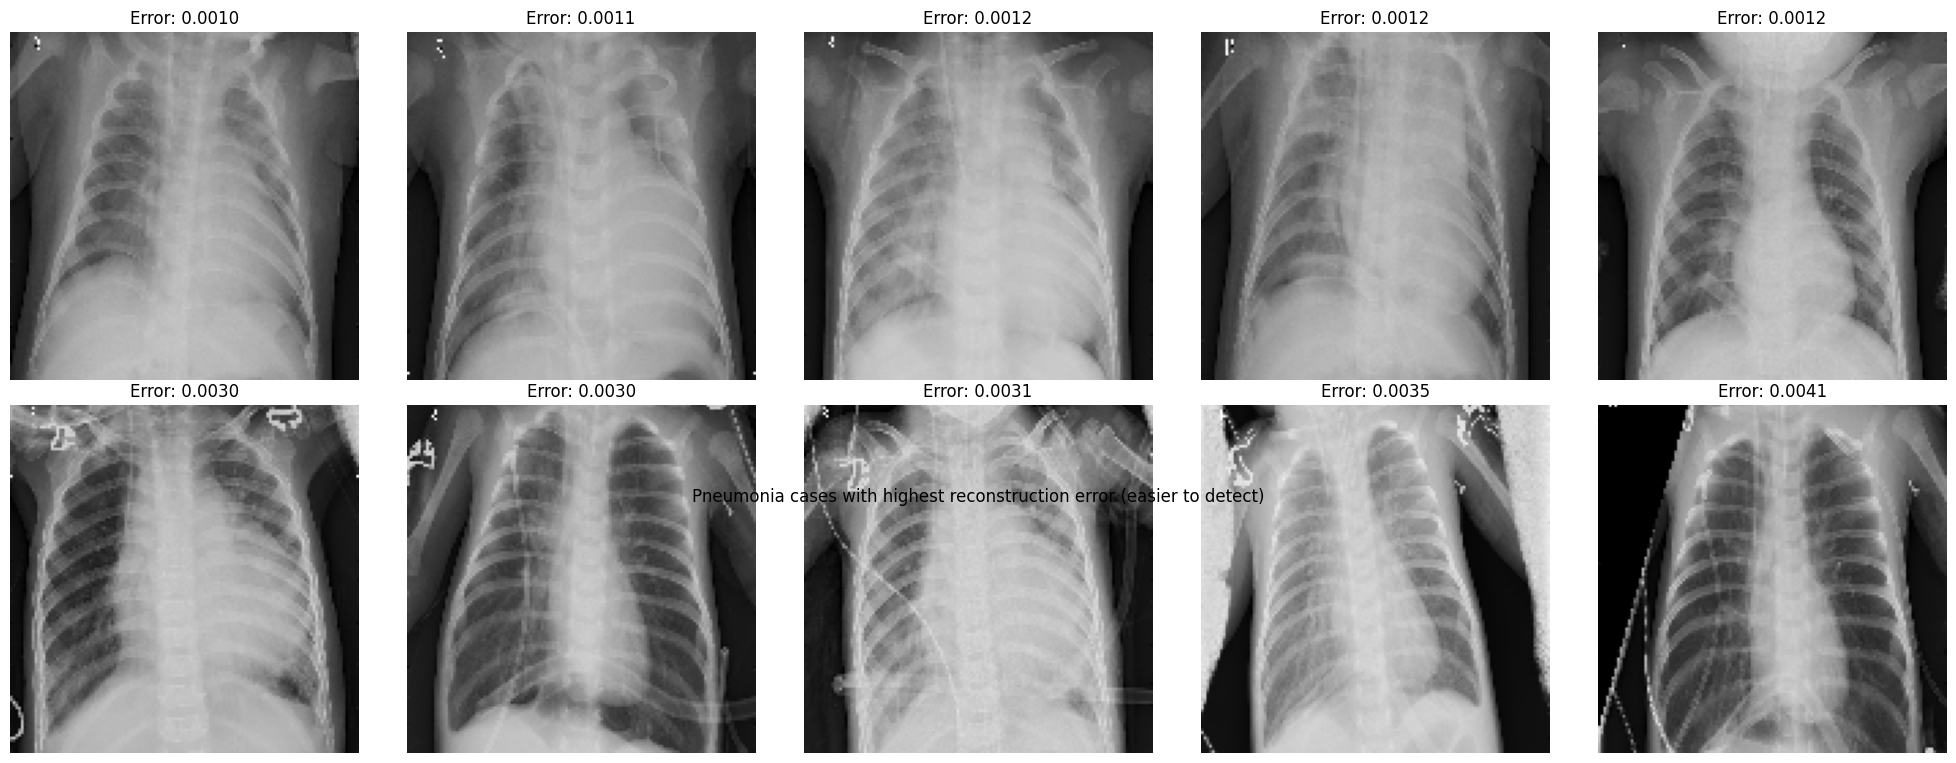

Model saved as 'xray_autoencoder_final.h5'


In [29]:
def main():
    
    train_generator, validation_generator, test_normal_generator, test_pneumonia_generator = load_data()
    
    
    autoencoder = build_autoencoder()
    
    
    def autoencoder_data_generator(generator):
        for batch in generator:
            yield (batch, batch)
    
    train_ae_gen = autoencoder_data_generator(train_generator)
    val_ae_gen = autoencoder_data_generator(validation_generator)
    
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint('xray_autoencoder_best.keras', monitor='val_loss', save_best_only=True)
    ]
    
    
    print("Training the model...")
    history = autoencoder.fit(
        train_ae_gen,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=val_ae_gen,
        validation_steps=len(validation_generator),
        callbacks=callbacks
    )
    
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if 'lr' in history.history:
        plt.plot(history.history['lr'])
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    
    
    test_normal_images = np.array([])
    for i in range(len(test_normal_generator)):
        batch = next(test_normal_generator)  # Fixed this line
        if i == 0:
            test_normal_images = batch
        else:
            test_normal_images = np.concatenate((test_normal_images, batch))
            break
    
    test_pneumonia_images = np.array([])
    for i in range(len(test_pneumonia_generator)):
        batch = next(test_pneumonia_generator)  # Fixed this line
        if i == 0:
            test_pneumonia_images = batch
        else:
            test_pneumonia_images = np.concatenate((test_pneumonia_images, batch))
            break
    
   
    print("Computing reconstruction errors...")
    normal_errors, normal_reconstructions = compute_reconstruction_error(autoencoder, test_normal_images)
    pneumonia_errors, pneumonia_reconstructions = compute_reconstruction_error(autoencoder, test_pneumonia_images)
    
    
    print("Plotting sample reconstructions for normal cases...")
    plot_reconstructions(test_normal_images, normal_reconstructions)
    
    
    print("Plotting sample reconstructions for pneumonia cases...")
    plot_reconstructions(test_pneumonia_images, pneumonia_reconstructions)
    
    
    print("Plotting error distributions...")
    plot_error_distributions(normal_errors, pneumonia_errors)
    
    
    print("Plotting ROC curve...")
    roc_auc, _ = plot_roc_curve(normal_errors, pneumonia_errors)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    
    print("Finding optimal threshold for anomaly detection...")
    optimal_threshold = find_optimal_threshold(normal_errors, pneumonia_errors)
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    
    print("Evaluating performance at optimal threshold...")
    y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(pneumonia_errors))])
    y_pred = np.concatenate([normal_errors > optimal_threshold, pneumonia_errors > optimal_threshold]).astype(int)
    
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Threshold: {optimal_threshold:.4f})')
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
   
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    
    pneumonia_indices_sorted = np.argsort(pneumonia_errors)
    low_error_indices = pneumonia_indices_sorted[:5]  # Lowest error pneumonia cases
    high_error_indices = pneumonia_indices_sorted[-5:]  # Highest error pneumonia cases
    
    plt.figure(figsize=(20, 8))
    
    
    plt.subplot(2, 1, 1)
    for i, idx in enumerate(low_error_indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(test_pneumonia_images[idx].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title(f"Error: {pneumonia_errors[idx]:.4f}")
        plt.axis('off')
    plt.suptitle("Pneumonia cases with lowest reconstruction error (harder to detect)", y=0.65)
    
    
    for i, idx in enumerate(high_error_indices):
        plt.subplot(2, 5, i+6)
        plt.imshow(test_pneumonia_images[idx].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title(f"Error: {pneumonia_errors[idx]:.4f}")
        plt.axis('off')
    plt.suptitle("Pneumonia cases with highest reconstruction error (easier to detect)", y=0.35)
    
    plt.tight_layout()
    plt.show()
    
   
    autoencoder.save('xray_autoencoder_final.h5')
    print("Model saved as 'xray_autoencoder_final.h5'")

if __name__ == "__main__":
    main()